Heisenberg model:

\begin{equation}
\mathcal{H} = \sum_i J_x \hat{\sigma}^x_i \hat{\sigma}^x_{i+1} + J_y \hat{\sigma}^y_i \hat{\sigma}^y_{i+1}+ J_z \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} + h \sum_i  \hat{\sigma}^z_i
\end{equation}

It is common to name the model depending on the values of $J_{x}, J_{y}$ and $J_{z}$: if $ J_{x}\neq J_{y}\neq J_{z}$, the model is called the Heisenberg XYZ model; in the case of $J=J_{x}=J_{y}\neq J_{z}=\Delta$ , it is the Heisenberg XXZ model

In [1]:
from qutip import mesolve, basis, jmat

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
    return jn(2*n,4*h/w) * np.cos(2*n*w*t)
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=False, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

## XXZ

In [1]:
%%time
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros
from qutip import *
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter    
from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_hamiltonians(N):
    sx,sy,sz= sigmax(),sigmay(),sigmaz()
    # nearest neighbour interaction
    
    empt = qzero(2**N) 
    H01, H02, H03, H11, H12, H13 = empt, empt, empt, empt, empt, empt
    
    for i in range(0,N-1):
        id = qeye(2**i)
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id, tensor(sx,tensor(sx, id1))).full())
        H02 = H02 + Qobj(tensor(id, tensor(sy,tensor(sy, id1))).full())
        H03 = H03 + Qobj(tensor(id, tensor(sz,tensor(sz, id1))).full())

    for i in range(0,N):
        id = qeye(2**i)
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id, tensor(sx, id1)).full())
        H12 = H12 + Qobj(tensor(id, tensor(sy, id1)).full())
        H13 = H13 + Qobj(tensor(id, tensor(sz, id1)).full())
        
    return H01, H02, H03, H11, H12, H13 

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H01, H02, H03, H11, H12, H13  = get_hamiltonians(N)
    H0 = H01 
    H1 = H13
    H = [H0,[H1,drive]]
    
    f_states, f_modes = floquet_modes(H, T, args=args, sort=True)
    return f_states, f_modes

N = 5
nprocs = 2
omega = 90.0
w = omega
hss = w/4 * np.linspace(1, 16.0, 300)
hs = np.sort(np.concatenate((hss,  w/4 * freezing_pts)))
#hs =  [w/4 * 1.5, w/4 * jn_zeros(0, 5)[0]]

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")

opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=2)
params = [{'h0':np.pi/256, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
data = p.map(floq_evolv,params)

print("running complete!")

running for N =  5 with 2 processors
running complete!
CPU times: user 1.57 s, sys: 205 ms, total: 1.78 s
Wall time: 25.7 s


In [2]:
iprmat = np.zeros((len(hs),2**N))
for xx,h in enumerate(hs):
    f_states = data[xx][0]
    f_en = data[xx][1]
    iprmat[xx,:] = [np.sum(np.abs(np.array(f_states[i])[:,0]) ** 4 )for i in range(2**N)]
    #iprmat[xx,:]= np.array([np.sum(np.array([np.abs(np.array(f_states[i])[:,0])**4 for i in range(2**N)]), axis=-1)])

[0.14576234 0.1457583  0.2497096  0.1666188  0.16661936 0.24970462
 0.24983269 0.16655247 0.16655675 0.24982457 0.14577472 0.14577889
 0.99862907 0.33318106 0.24989797 0.249655   0.249655   0.24989797
 0.33318106 0.99862907 0.14577889 0.14577472 0.24982457 0.16655675
 0.16655247 0.24983269 0.24970462 0.16661936 0.1666188  0.2497096
 0.1457583  0.14576234]


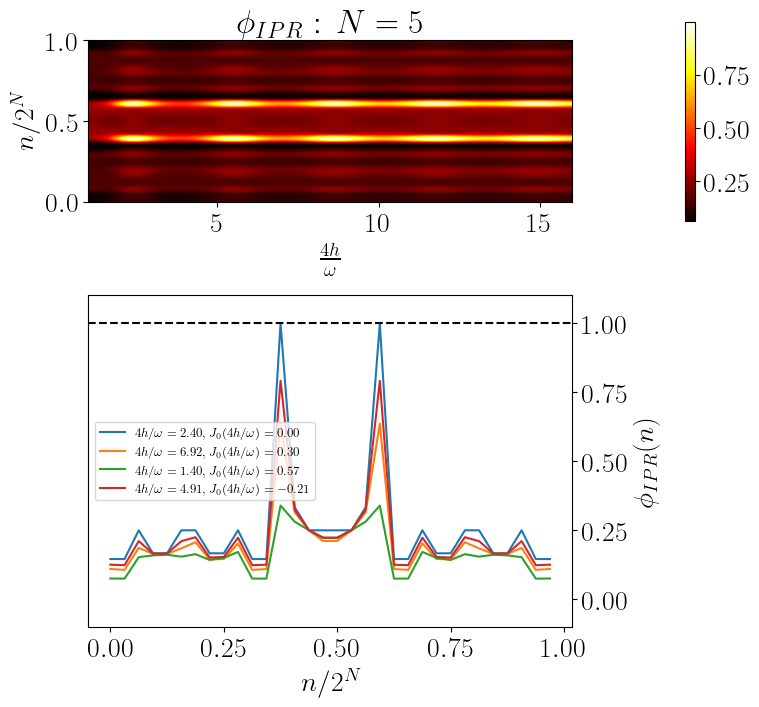

In [7]:
plt.rcParams.update({
    "figure.figsize": (7.5,7.5),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})

etas = 4 * np.array(hs)/w

fig = plt.figure(constrained_layout=True)
ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/2^N$')
'''
for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=1.5)
'''
im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)

#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=0.001))
n0 = idx[0]
print(iprmat[n0])

#High IPR
idx, = np.where(np.isclose(etas, 7.0, atol=0.1))
n1 = idx[0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.1))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 5.0, atol=0.1))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2**N)/(2**N)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 1000)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")

crosssec_ax.set_xlabel(r"$n/2^N$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
crosssec_ax.set_ylim(-0.1, 1.1)
crosssec_ax.axhline(y=1.0, linestyle ='--', color='black')
plt.legend(fontsize =9, loc=6)

figname = fr"tfim_plus_lng_sx_${N}$_.pdf"
#plt.savefig(figname)
plt.show()